In [1]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('E:\Jupyter_files\OnlineRetail.csv')

df = df[
    (df.Quantity > 0) &
    (df.UnitPrice > 0)
]

df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
499967,578702,20719,WOODLAND CHARLOTTE BAG,10,11/25/2011 10:58,0.85,15382.0,United Kingdom
346583,567190,23208,LUNCH BAG VINTAGE LEAF DESIGN,10,9/19/2011 9:14,1.65,18226.0,United Kingdom
62153,541497,22817,CARD SUKI BIRTHDAY,4,1/18/2011 15:19,0.42,NaN,United Kingdom
167177,550986,21716,BOYS VINTAGE TIN SEASIDE BUCKET,1,4/21/2011 18:06,4.96,NaN,United Kingdom
31533,538992,22578,WOODEN STAR CHRISTMAS SCANDINAVIAN,3,12/15/2010 11:56,0.85,15950.0,United Kingdom
254929,559337,22961,JAM MAKING SET PRINTED,1,7/7/2011 16:27,3.29,NaN,United Kingdom
230218,557129,22355,CHARLOTTE BAG SUKI DESIGN,4,6/16/2011 19:59,0.85,17841.0,United Kingdom
318362,564835,22653,BUTTON BOX,1,8/30/2011 12:31,1.63,NaN,United Kingdom
330289,565917,22998,TRAVEL CARD WALLET KEEP CALM,1,9/7/2011 16:15,0.83,NaN,United Kingdom
519995,580221,21212,PACK OF 72 RETROSPOT CAKE CASES,24,12/2/2011 12:13,0.55,14092.0,United Kingdom


In [3]:
df = df[~df.StockCode.isin(['POST', 'DOT', 'M', 'AMAZONFEE', 'BANK CHARGES', 'C2', 'S'])]

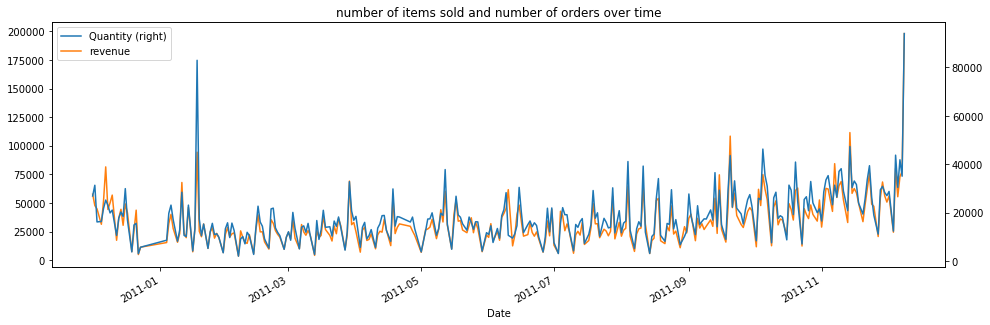

In [4]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['Date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['revenue'] = df.Quantity * df.UnitPrice

df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='Quantity',
    figsize=(16, 5)
)

In [5]:
df.nlargest(5, columns='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.60
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,2011-10-27,1008.00
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,2011-05-27,3096.00
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,2011-02-22,3202.92


In [6]:
df = df[~df.CustomerID.isin([16446.0, 12346.0])]

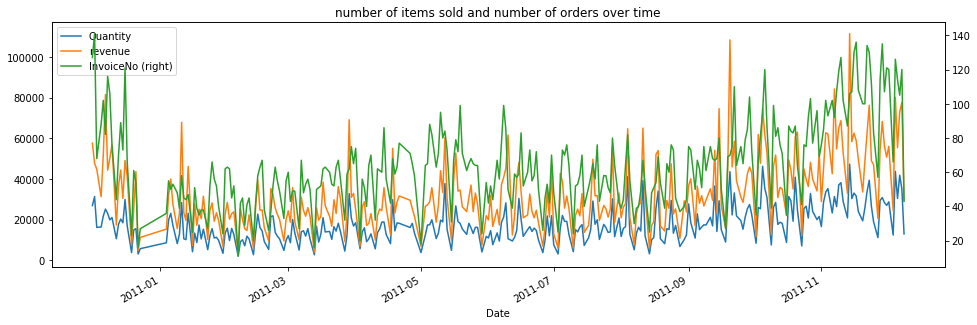

In [7]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum', 'InvoiceNo': 'nunique'}
).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='InvoiceNo',
    figsize=(16, 5)
)

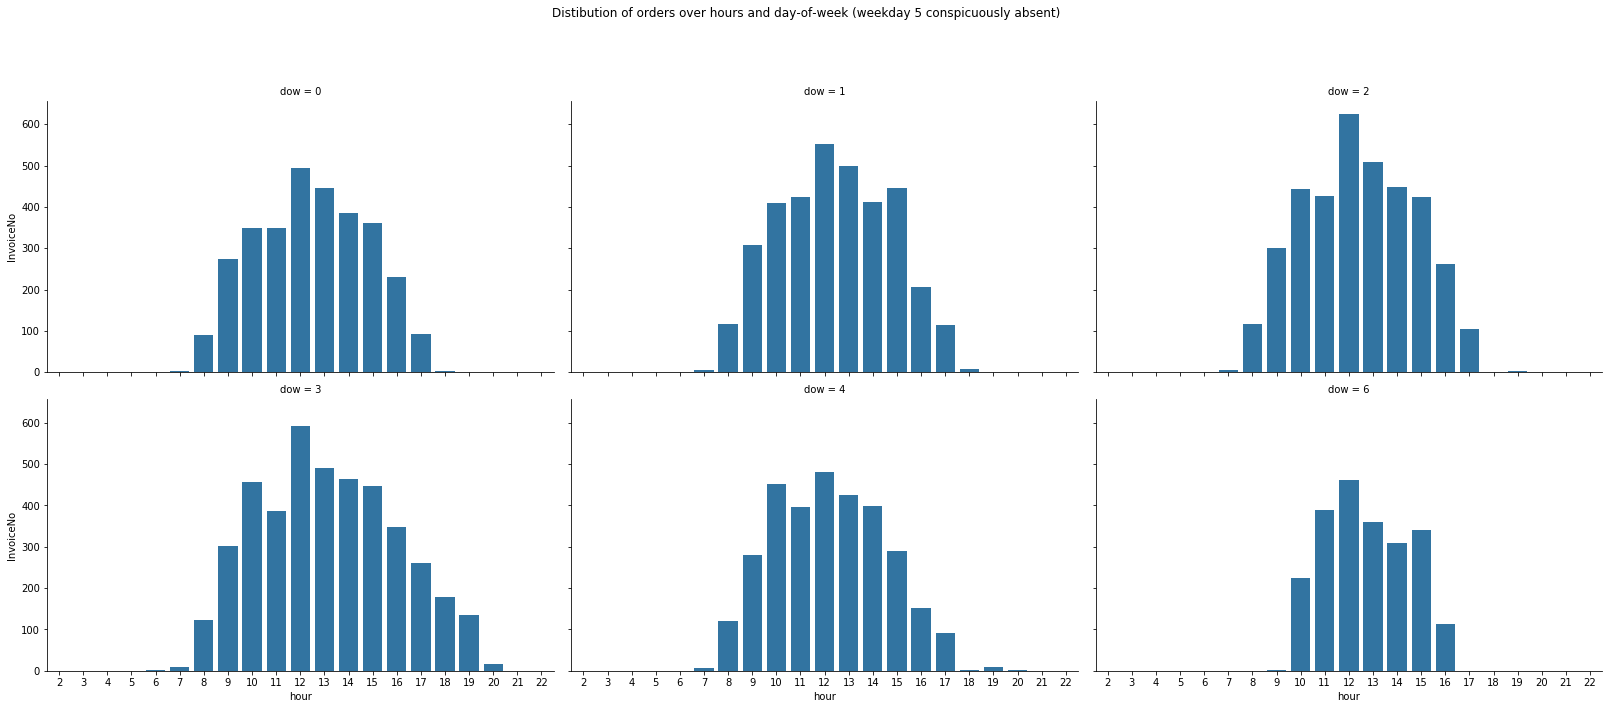

In [8]:
sns.FacetGrid(
    data=df.assign(
        hour=df.InvoiceDate.dt.hour,
        dow=df.InvoiceDate.dt.weekday,
    ).groupby(['dow', 'hour'], as_index=False).agg({'InvoiceNo': 'nunique'}),
    col='dow', col_wrap=3,
    height=5, aspect=1.5, 
).map(
    sns.barplot, 'hour', 'InvoiceNo', order=[h for h in range(2, 23)]
)
plt.suptitle('Distibution of orders over hours and day-of-week (weekday 5 conspicuously absent)')
plt.subplots_adjust(top=0.85)

In [9]:
df = (
    df
    .assign(
        dNormalPrice=lambda d: d.UnitPrice 
            / d.groupby('StockCode').UnitPrice.transform('median') 
    )
    .pipe(
        lambda d: d[
            (d['dNormalPrice'] > 1./3) &
            (d['dNormalPrice'] < 3.)
        ]
    )
    .drop(columns=['dNormalPrice'])
)

In [10]:
df = df.groupby(['Date', 'StockCode', 'Country'], as_index=False).agg({
    'Description': 'first',
    'Quantity': 'sum', 
    'revenue': 'sum'
})
df['Description'] = df.groupby('StockCode').Description.transform('first')

df['UnitPrice'] = df['revenue'] / df['Quantity'] # implicit quantity-weighted avg of prices

In [11]:
df.to_parquet('ecom_sample_clean.parquet')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor


feature_generator = ColumnTransformer(
    [
        ('item_id', OneHotEncoder(), ['item_id']), 
        ('date', OneHotEncoder(), ['date']),
        ('item_description', 
             CountVectorizer(min_df=0.05, ngram_range=(1, 3)), 
             'item_description'),
        ('numeric_feats', StandardScaler(), 
             ['day_of_week', 'stock_age_in_days'])
    ], remainder='drop'
)

model_q = Pipeline([
    ('feat_proc', feature_generator),
    ('model_q', RandomForestRegressor()) 
])
model_p = Pipeline([
    ('feat_proc', feature_generator),
    ('model_p', RandomForestRegressor())
])

In [ ]:
from sklearn.model_selection import KFold

# Since Q might be 0, can't just take logs. This is a quick
# workaround for demonstration. Better options exist.
df_mdl['LnP'] = np.log1p(df_mdl['P'])
df_mdl['LnQ'] = np.log1p(df_mdl['Q'])
elast_estimates = list()

# Step 1: split into two halves
for idx_aux, idx_inf in KFold(
    n_splits=2, shuffle=True).split(df_mdl):
    
    df_aux = df_mdl.iloc[idx_aux]
    df_inf = df_mdl.iloc[idx_inf].copy()
    
    # Step 2+3: fit auxiliary models on first half
    model_q.fit(df_aux, df_aux['LnQ'])
    model_p.fit(df_aux, df_aux['LnP'])
    
    # Step 4: residualize in second half
    df_inf = df_inf.assign(
        LnP_res = df_inf['LnP'] - model_p.predict(df_inf),
        LnQ_res = df_inf['LnQ'] - model_q.predict(df_inf),
    )
    
   # Step 5: DML inference
    elast = (
        df_inf['LnP_res'].dot(df_inf['LnQ_res'])
        /
        df_inf['LnP_res'].dot(df_inf['LnP'])
        # the last part here deviates from standard OLS solution
    )
    
    print('DML elasticity:', elast)
    elast_estimates.append(elast)

    print('OLS elasticity for comparison:',
        df_inf['LnP_res'].dot(df_inf['LnQ_res'])
        /
        df_inf['LnP_res'].dot(df_inf['LnP_res'])
    )    

# Step 6: Take the mean of both estimates
print("DML efficient estimate of elasticity:", np.mean(elast_estimates))